In [6]:
import pandas as pd
import polars as pl
import time

pandas_start = time.time()
Data_source = pd.read_csv('../data/cybersecurity_threat_detection_logs.csv')
pandas_end = time.time()
print(f"Pandas loading time: {pandas_end - pandas_start} seconds")

polars_start = time.time()
Data_source_pl = pl.read_csv('../data/cybersecurity_threat_detection_logs.csv')
polars_end = time.time()
print(f"Polars loading time: {polars_end - polars_start} seconds")


Pandas loading time: 5.3565521240234375 seconds
Polars loading time: 0.3017709255218506 seconds


In [3]:
columns = Data_source_pl.get_columns()
print("Columns in the dataset:")
for col in columns:
    print(col)



Columns in the dataset:
shape: (6_000_000,)
Series: 'timestamp' [str]
[
	"2024-05-01T00:00:00"
	"2024-07-18T00:00:00"
	"2024-04-07T00:00:00"
	"2024-10-26T00:00:00"
	"2024-10-31T00:00:00"
	…
	"2024-06-06T00:00:00"
	"2024-11-14T00:00:00"
	"2024-03-31T00:00:00"
	"2024-06-26T00:00:00"
	"2024-03-21T00:00:00"
]
shape: (6_000_000,)
Series: 'source_ip' [str]
[
	"192.168.1.125"
	"192.168.1.201"
	"192.168.1.248"
	"192.168.1.236"
	"192.168.1.221"
	…
	"235.165.118.37"
	"192.168.1.107"
	"192.168.1.131"
	"192.168.1.4"
	"59.151.57.2"
]
shape: (6_000_000,)
Series: 'dest_ip' [str]
[
	"192.168.1.124"
	"192.168.1.201"
	"192.168.1.15"
	"192.168.1.219"
	"192.168.1.61"
	…
	"192.168.1.60"
	"192.168.1.192"
	"192.168.1.49"
	"192.168.1.247"
	"192.168.1.47"
]
shape: (6_000_000,)
Series: 'protocol' [str]
[
	"TCP"
	"ICMP"
	"HTTP"
	"HTTP"
	"ICMP"
	…
	"SSH"
	"TCP"
	"TCP"
	"TCP"
	"TCP"
]
shape: (6_000_000,)
Series: 'action' [str]
[
	"blocked"
	"blocked"
	"allowed"
	"allowed"
	"allowed"
	…
	"blocked"
	"allowed"
	"allo

In [4]:
# head of the dataset

print("First 5 rows of the dataset:")
print(Data_source_pl.head(5))

First 5 rows of the dataset:
shape: (5, 10)
┌───────────┬───────────┬───────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ timestamp ┆ source_ip ┆ dest_ip   ┆ protocol ┆ … ┆ log_type  ┆ bytes_tra ┆ user_agen ┆ request_p │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆   ┆ ---       ┆ nsferred  ┆ t         ┆ ath       │
│ str       ┆ str       ┆ str       ┆ str      ┆   ┆ str       ┆ ---       ┆ ---       ┆ ---       │
│           ┆           ┆           ┆          ┆   ┆           ┆ i64       ┆ str       ┆ str       │
╞═══════════╪═══════════╪═══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2024-05-0 ┆ 192.168.1 ┆ 192.168.1 ┆ TCP      ┆ … ┆ firewall  ┆ 10889     ┆ Nmap      ┆ /         │
│ 1T00:00:0 ┆ .125      ┆ .124      ┆          ┆   ┆           ┆           ┆ Scripting ┆           │
│ 0         ┆           ┆           ┆          ┆   ┆           ┆           ┆ Engine    ┆           │
│ 2024-07-1 ┆ 192.168.1 ┆ 192.168.1 ┆ ICMP     

In [5]:
# timestamp column analysis

timestamp_series = Data_source_pl['timestamp']
min_timestamp = timestamp_series.min()
max_timestamp = timestamp_series.max()
print(f"Minimum timestamp: {min_timestamp}")
print(f"Maximum timestamp: {max_timestamp}")




Minimum timestamp: 2024-01-01T00:00:00
Maximum timestamp: 2024-12-30T00:00:00


In [6]:
# Extract timestamp for date and time

Data_source_pl_1 = Data_source_pl.with_columns([
    pl.col('timestamp').str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S").alias('timestamp')
])

Data_source_pl_2 = Data_source_pl_1.with_columns([
    pl.col('timestamp').dt.date().alias('date'),
    pl.col('timestamp').dt.hour().alias('hour')
])

# Then get hourly distribution of bytes transferred
hourly_bytes = Data_source_pl_2.group_by('hour').agg([
    pl.sum('bytes_transferred').alias('total_bytes_transferred')
]).sort('hour')

print("Hourly distribution of bytes transferred:")
print(hourly_bytes)

Hourly distribution of bytes transferred:
shape: (1, 2)
┌──────┬─────────────────────────┐
│ hour ┆ total_bytes_transferred │
│ ---  ┆ ---                     │
│ i8   ┆ i64                     │
╞══════╪═════════════════════════╡
│ 0    ┆ 150278953326            │
└──────┴─────────────────────────┘


In [7]:
# unique hours in the dataset

unique_hours = Data_source_pl_2.select(pl.col('hour').unique().sort())
print("Unique hours in the dataset:")
print(unique_hours)

Unique hours in the dataset:
shape: (1, 1)
┌──────┐
│ hour │
│ ---  │
│ i8   │
╞══════╡
│ 0    │
└──────┘


Findings : Then there is only date wise analysis.

In [8]:
# check whether any date missing through out this 2024 year by unique values in date column

date_series = Data_source_pl_2['date']
unique_dates = date_series.unique().sort()
print("Unique dates in the dataset:")
for date in unique_dates:
    print(date)

#since year is 2024, check if all dates from 2024-01-01 to 2024-12-31 are present
from datetime import datetime, timedelta
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 12, 31)
date_set = set(unique_dates.to_list())
missing_dates = []
current_date = start_date
while current_date <= end_date:
    if current_date.date() not in date_set:
        missing_dates.append(current_date.date())
    current_date += timedelta(days=1)

if missing_dates:
    print("Missing dates in the dataset:")
    for date in missing_dates:
        print(date)
else:
    print("No missing dates in the dataset.")


Unique dates in the dataset:
2024-01-01
2024-01-02
2024-01-03
2024-01-04
2024-01-05
2024-01-06
2024-01-07
2024-01-08
2024-01-09
2024-01-10
2024-01-11
2024-01-12
2024-01-13
2024-01-14
2024-01-15
2024-01-16
2024-01-17
2024-01-18
2024-01-19
2024-01-20
2024-01-21
2024-01-22
2024-01-23
2024-01-24
2024-01-25
2024-01-26
2024-01-27
2024-01-28
2024-01-29
2024-01-30
2024-01-31
2024-02-01
2024-02-02
2024-02-03
2024-02-04
2024-02-05
2024-02-06
2024-02-07
2024-02-08
2024-02-09
2024-02-10
2024-02-11
2024-02-12
2024-02-13
2024-02-14
2024-02-15
2024-02-16
2024-02-17
2024-02-18
2024-02-19
2024-02-20
2024-02-21
2024-02-22
2024-02-23
2024-02-24
2024-02-25
2024-02-26
2024-02-27
2024-02-28
2024-02-29
2024-03-01
2024-03-02
2024-03-03
2024-03-04
2024-03-05
2024-03-06
2024-03-07
2024-03-08
2024-03-09
2024-03-10
2024-03-11
2024-03-12
2024-03-13
2024-03-14
2024-03-15
2024-03-16
2024-03-17
2024-03-18
2024-03-19
2024-03-20
2024-03-21
2024-03-22
2024-03-23
2024-03-24
2024-03-25
2024-03-26
2024-03-27
2024-03-28
202

Only 2024-12-31 is missing from the dataset.other dates are present.

In [9]:
# How many unique source IPs are there?

unique_source_ips = Data_source_pl.select(pl.col('source_ip').unique())
print(f"Number of unique source IPs: {unique_source_ips.height}")

missing_source_ips = Data_source_pl.filter(~pl.col('source_ip').is_in(unique_source_ips['source_ip']))
print(f"Number of missing source IPs: {missing_source_ips.height}")

print("Missing source IPs:")
print(missing_source_ips)

#check all ips in right format
import re
ip_pattern = re.compile(r'^(\d{1,3}\.){3}\d{1,3}$')
invalid_ips = []
for ip in unique_source_ips['source_ip']:
    if not ip_pattern.match(ip):
        invalid_ips.append(ip)
if invalid_ips:
    print("Invalid IP addresses found:")
    for ip in invalid_ips:
        print(ip)
else:
    print("All source IPs are in valid format.")

Number of unique source IPs: 354
Number of missing source IPs: 0
Missing source IPs:
shape: (0, 10)
┌───────────┬───────────┬─────────┬──────────┬───┬──────────┬────────────┬────────────┬────────────┐
│ timestamp ┆ source_ip ┆ dest_ip ┆ protocol ┆ … ┆ log_type ┆ bytes_tran ┆ user_agent ┆ request_pa │
│ ---       ┆ ---       ┆ ---     ┆ ---      ┆   ┆ ---      ┆ sferred    ┆ ---        ┆ th         │
│ str       ┆ str       ┆ str     ┆ str      ┆   ┆ str      ┆ ---        ┆ str        ┆ ---        │
│           ┆           ┆         ┆          ┆   ┆          ┆ i64        ┆            ┆ str        │
╞═══════════╪═══════════╪═════════╪══════════╪═══╪══════════╪════════════╪════════════╪════════════╡
└───────────┴───────────┴─────────┴──────────┴───┴──────────┴────────────┴────────────┴────────────┘
All source IPs are in valid format.


/tmp/ipykernel_5433/3502972175.py:6: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  missing_source_ips = Data_source_pl.filter(~pl.col('source_ip').is_in(unique_source_ips['source_ip']))


For this kind a large dataset, source ips are only 354 unique ips.

In [10]:
#sort unique source ips by frequency
source_ip_freq = Data_source_pl.group_by('source_ip').agg([
    pl.len().alias('frequency')
]).sort('frequency', descending=True)  

print("Source IPs sorted by frequency:")

for row in source_ip_freq.iter_rows():
    print(f"Source IP: {row[0]}, Frequency: {row[1]}")

Source IPs sorted by frequency:
Source IP: 59.211.9.207, Frequency: 18295
Source IP: 109.106.120.222, Frequency: 18273
Source IP: 88.72.40.56, Frequency: 18252
Source IP: 185.225.185.68, Frequency: 18239
Source IP: 122.63.201.122, Frequency: 18229
Source IP: 229.140.23.152, Frequency: 18203
Source IP: 44.137.187.63, Frequency: 18202
Source IP: 61.72.172.125, Frequency: 18193
Source IP: 114.207.221.220, Frequency: 18193
Source IP: 166.19.156.163, Frequency: 18178
Source IP: 109.9.8.24, Frequency: 18176
Source IP: 25.169.111.91, Frequency: 18173
Source IP: 55.139.34.186, Frequency: 18164
Source IP: 13.221.29.40, Frequency: 18146
Source IP: 187.14.173.168, Frequency: 18137
Source IP: 208.223.2.195, Frequency: 18133
Source IP: 103.172.167.96, Frequency: 18126
Source IP: 19.182.162.16, Frequency: 18126
Source IP: 144.138.68.192, Frequency: 18105
Source IP: 207.79.62.15, Frequency: 18105
Source IP: 240.226.147.148, Frequency: 18104
Source IP: 216.197.199.15, Frequency: 18100
Source IP: 55.23

In [11]:
#likewise for destination IPs

unique_destination_ips = Data_source_pl.select(pl.col('dest_ip').unique())
print(f"Number of unique destination IPs: {unique_destination_ips.height}")

missing_destination_ips = Data_source_pl.filter(~pl.col('dest_ip').is_in(unique_destination_ips['dest_ip']))
print(f"Number of missing destination IPs: {missing_destination_ips.height}")

print("Missing destination IPs:")
print(missing_destination_ips)

#check all destination ips in right format
invalid_dest_ips = []
for ip in unique_destination_ips['dest_ip']:
    if not ip_pattern.match(ip):
        invalid_dest_ips.append(ip)
if invalid_dest_ips:
    print("Invalid destination IP addresses found:")
    for ip in invalid_dest_ips:
        print(ip)
else:
    print("All destination IPs are in valid format.")

#sort unique destination ips by frequency
destination_ip_freq = Data_source_pl.group_by('dest_ip').agg([
    pl.len().alias('frequency')
]).sort('frequency', descending=True)   
print("Destination IPs sorted by frequency:")

for row in destination_ip_freq.iter_rows():
    print(f"Destination IP: {row[0]}, Frequency: {row[1]}") 
# Top 10 source IPs by bytes transferred
top_source_ips = Data_source_pl.group_by('source_ip').agg([
    pl.sum('bytes_transferred').alias('total_bytes_transferred')
]).sort('total_bytes_transferred', descending=True).head(10)    


Number of unique destination IPs: 254
Number of missing destination IPs: 0
Missing destination IPs:
shape: (0, 10)
┌───────────┬───────────┬─────────┬──────────┬───┬──────────┬────────────┬────────────┬────────────┐
│ timestamp ┆ source_ip ┆ dest_ip ┆ protocol ┆ … ┆ log_type ┆ bytes_tran ┆ user_agent ┆ request_pa │
│ ---       ┆ ---       ┆ ---     ┆ ---      ┆   ┆ ---      ┆ sferred    ┆ ---        ┆ th         │
│ str       ┆ str       ┆ str     ┆ str      ┆   ┆ str      ┆ ---        ┆ str        ┆ ---        │
│           ┆           ┆         ┆          ┆   ┆          ┆ i64        ┆            ┆ str        │
╞═══════════╪═══════════╪═════════╪══════════╪═══╪══════════╪════════════╪════════════╪════════════╡
└───────────┴───────────┴─────────┴──────────┴───┴──────────┴────────────┴────────────┴────────────┘
All destination IPs are in valid format.
Destination IPs sorted by frequency:
Destination IP: 192.168.1.5, Frequency: 24140
Destination IP: 192.168.1.135, Frequency: 24121
Destin

/tmp/ipykernel_5433/1224054436.py:6: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  missing_destination_ips = Data_source_pl.filter(~pl.col('dest_ip').is_in(unique_destination_ips['dest_ip']))


In [12]:
#protocol analysis

#missing protocol values
missing_protocols = Data_source_pl.filter(pl.col('protocol').is_null())
print(f"Number of missing protocol values: {missing_protocols.height}")

# number of unique protocols and their frequencies
protocol_freq = Data_source_pl.group_by('protocol').agg([
    pl.len().alias('frequency')
]).sort('frequency', descending=True)   
print("Protocol frequencies:")
for row in protocol_freq.iter_rows():
    print(f"Protocol: {row[0]}, Frequency: {row[1]}")

Number of missing protocol values: 0
Protocol frequencies:
Protocol: TCP, Frequency: 1497493
Protocol: HTTP, Frequency: 1201528
Protocol: HTTPS, Frequency: 1199970
Protocol: UDP, Frequency: 900422
Protocol: ICMP, Frequency: 599903
Protocol: SSH, Frequency: 300464
Protocol: FTP, Frequency: 300220


In [13]:
#action analysis

# missing action values
missing_actions = Data_source_pl.filter(pl.col('action').is_null())
print(f"Number of missing action values: {missing_actions.height}")

# number of unique actions and their frequencies
action_freq = Data_source_pl.group_by('action').agg([
    pl.len().alias('frequency')
]).sort('frequency', descending=True)   
print("Action frequencies:")
for row in action_freq.iter_rows():
    print(f"Action: {row[0]}, Frequency: {row[1]}")

Number of missing action values: 0
Action frequencies:
Action: allowed, Frequency: 3000646
Action: blocked, Frequency: 2999354


Pretty unusual for a dataset of this size.

In [14]:
#threat label analysis

# missing threat_label values
missing_threat_labels = Data_source_pl.filter(pl.col('threat_label').is_null())
print(f"Number of missing threat_label values: {missing_threat_labels.height}")

# number of unique threat labels and their frequencies
threat_label_freq = Data_source_pl.group_by('threat_label').agg([
    pl.len().alias('frequency')
]).sort('frequency', descending=True)   
print("Threat label frequencies:")
for row in threat_label_freq.iter_rows():
    print(f"Threat Label: {row[0]}, Frequency: {row[1]}")

Number of missing threat_label values: 0


Threat label frequencies:
Threat Label: benign, Frequency: 5517611
Threat Label: suspicious, Frequency: 360883
Threat Label: malicious, Frequency: 121506


In [15]:
#checking each threat level vs how many blocked actions were taken
threat_action_analysis = Data_source_pl.group_by('threat_label', 'action').agg([
    pl.len().alias('count')
]).sort(['threat_label', 'action'])   
print("Threat level vs Blocked actions analysis:")
for row in threat_action_analysis.iter_rows():
    print(f"Threat Label: {row[0]}, Action: {row[1]}, Count: {row[2]}")



Threat level vs Blocked actions analysis:
Threat Label: benign, Action: allowed, Count: 2759501
Threat Label: benign, Action: blocked, Count: 2758110
Threat Label: malicious, Action: allowed, Count: 60839
Threat Label: malicious, Action: blocked, Count: 60667
Threat Label: suspicious, Action: allowed, Count: 180306
Threat Label: suspicious, Action: blocked, Count: 180577


Interestingly half of benign threats have blocked actions and half allowed actions.
Only 10% of malicious threats are blocked actions, 90% are allowed actions. This is a major quality issue in the dataset.
Again half of suspicious threats are blocked actions, half allowed actions.

Lets further analyze the blocked actions vs threat levels.

In [16]:
#Threat label benign analysis

#threat label benign with allowed action's mean bytes transferred and unique values of protocols and frequencies

benign_allowed_analysis = Data_source_pl.filter((pl.col('threat_label') == 'benign') & (pl.col('action') == 'allowed'))
mean_bytes_benign_allowed = benign_allowed_analysis.select(pl.col('bytes_transferred').mean()).item()
unique_protocols_benign_allowed = benign_allowed_analysis.select(pl.col('protocol').unique())
protocol_freq_benign_allowed = benign_allowed_analysis.group_by('protocol').agg([
    pl.len().alias('frequency')
]).sort('frequency', descending=True)   
print(f"Mean bytes transferred for benign allowed actions: {mean_bytes_benign_allowed}")
print("Unique protocols for benign allowed actions:")
for protocol in unique_protocols_benign_allowed['protocol']:
    print(protocol)
print("Protocol frequencies for benign allowed actions:")
for row in protocol_freq_benign_allowed.iter_rows():
    print(f"Protocol: {row[0]}, Frequency: {row[1]}")



benign_blocked_analysis = Data_source_pl.filter((pl.col('threat_label') == 'benign') & (pl.col('action') == 'blocked'))
mean_bytes_benign_blocked = benign_blocked_analysis.select(pl.col('bytes_transferred').mean()).item()
unique_protocols_benign_blocked = benign_blocked_analysis.select(pl.col('protocol').unique())
protocol_freq_benign_blocked = benign_blocked_analysis.group_by('protocol').agg([
    pl.len().alias('frequency')
]).sort('frequency', descending=True)   
print(f"Mean bytes transferred for benign blocked actions: {mean_bytes_benign_blocked}")
print("Unique protocols for benign blocked actions:")
for protocol in unique_protocols_benign_blocked['protocol']:
    print(protocol)
print("Protocol frequencies for benign blocked actions:")
for row in protocol_freq_benign_blocked.iter_rows():
    print(f"Protocol: {row[0]}, Frequency: {row[1]}")




Mean bytes transferred for benign allowed actions: 25048.35478914485
Unique protocols for benign allowed actions:
ICMP
SSH
TCP
HTTP
UDP
FTP
HTTPS
Protocol frequencies for benign allowed actions:
Protocol: TCP, Frequency: 705413
Protocol: HTTP, Frequency: 566906
Protocol: HTTPS, Frequency: 565956
Protocol: UDP, Frequency: 423999
Protocol: ICMP, Frequency: 241171
Protocol: FTP, Frequency: 130629
Protocol: SSH, Frequency: 125427
Mean bytes transferred for benign blocked actions: 25045.112768163708
Unique protocols for benign blocked actions:
FTP
HTTPS
UDP
ICMP
SSH
TCP
HTTP
Protocol frequencies for benign blocked actions:
Protocol: TCP, Frequency: 705597
Protocol: HTTP, Frequency: 565459
Protocol: HTTPS, Frequency: 564858
Protocol: UDP, Frequency: 424630
Protocol: ICMP, Frequency: 240265
Protocol: FTP, Frequency: 131350
Protocol: SSH, Frequency: 125951


Lets skip that and move to next column analysis.

In [17]:
#log type analysis

#missing log type values
missing_log_types = Data_source_pl.filter(pl.col('log_type').is_null())
print(f"Number of missing log type values: {missing_log_types.height}")

# unique log types and their frequencies
log_type_freq = Data_source_pl.group_by('log_type').agg([
    pl.len().alias('frequency')
]).sort('frequency', descending=True)   
print("Log type frequencies:")
for row in log_type_freq.iter_rows():
    print(f"Log Type: {row[0]}, Frequency: {row[1]}")

Number of missing log type values: 0
Log type frequencies:
Log Type: application, Frequency: 2001768
Log Type: ids, Frequency: 1999556
Log Type: firewall, Frequency: 1998676


In [18]:
# Bytes transferred analysis

# missing bytes transferred values
missing_bytes_transferred = Data_source_pl.filter(pl.col('bytes_transferred').is_null())
print(f"Number of missing bytes transferred values: {missing_bytes_transferred.height}")


Number of missing bytes transferred values: 0


In [19]:
#user agent analysis

# missing user agent values
missing_user_agents = Data_source_pl.filter(pl.col('user_agent').is_null())
print(f"Number of missing user agent values: {missing_user_agents.height}")


#get sample user agents
sample_user_agents = Data_source_pl.select(pl.col('user_agent').unique().sort()).head(10)
print("Sample unique user agents:")
for ua in sample_user_agents['user_agent']:
    print(ua)

Number of missing user agent values: 0
Sample unique user agents:
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36
Nmap Scripting Engine
SQLMap/1.6-dev
curl/7.64.1


In [20]:
#So user agents can be divided into browse users and scripted engines.

# For browse users (example Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36)
#for browse users transform into browser type, os type

# User agent categorization and analysis

import re

# Function to categorize user agents
def categorize_user_agent(ua):
    if ua.startswith('Mozilla/5.0'):
        return 'browser'
    elif any(keyword in ua.lower() for keyword in ['nmap', 'sqlmap', 'curl', 'python', 'script']):
        return 'scripted_engine'
    else:
        return 'other'

# Function to extract browser and OS from browser user agents
def extract_browser_os(ua):
    if not ua.startswith('Mozilla/5.0'):
        return None, None
    # Simple regex for browser (Chrome, Safari, etc.)
    browser_match = re.search(r'(Chrome|Firefox|Safari|Edge)/[\d.]+', ua)
    browser = browser_match.group(1) if browser_match else 'Unknown'
    # Simple regex for OS
    os_match = re.search(r'\(([^;]+);', ua)
    os = os_match.group(1) if os_match else 'Unknown'
    return browser, os

# Apply categorization
Data_source_pl = Data_source_pl.with_columns([
    pl.col('user_agent').map_elements(categorize_user_agent, return_dtype=pl.Utf8).alias('user_agent_category')
])

# Extract browser and OS for browsers
browser_data = Data_source_pl.filter(pl.col('user_agent_category') == 'browser').with_columns([
    pl.col('user_agent').map_elements(lambda ua: extract_browser_os(ua)[0], return_dtype=pl.Utf8).alias('browser_type'),
    pl.col('user_agent').map_elements(lambda ua: extract_browser_os(ua)[1], return_dtype=pl.Utf8).alias('os_type')
])

# Basic analysis: frequencies of categories
category_freq = Data_source_pl.group_by('user_agent_category').agg([
    pl.len().alias('count')
]).sort('count', descending=True)
print("User agent category frequencies:")
print(category_freq)

# Browser analysis: frequencies of browser types and OS types
browser_freq = browser_data.group_by('browser_type').agg([
    pl.len().alias('count')
]).sort('count', descending=True)
print("\nBrowser type frequencies:")
print(browser_freq)

os_freq = browser_data.group_by('os_type').agg([
    pl.len().alias('count')
]).sort('count', descending=True)
print("\nOS type frequencies:")
print(os_freq)

# Scripted engine analysis: unique scripted engines and frequencies
scripted_data = Data_source_pl.filter(pl.col('user_agent_category') == 'scripted_engine')
scripted_freq = scripted_data.group_by('user_agent').agg([
    pl.len().alias('count')
]).sort('count', descending=True)
print("\nScripted engine frequencies:")
print(scripted_freq.head(10))  # Top 10 for brevity

User agent category frequencies:
shape: (2, 2)
┌─────────────────────┬─────────┐
│ user_agent_category ┆ count   │
│ ---                 ┆ ---     │
│ str                 ┆ u32     │
╞═════════════════════╪═════════╡
│ scripted_engine     ┆ 3599216 │
│ browser             ┆ 2400784 │
└─────────────────────┴─────────┘

Browser type frequencies:
shape: (1, 2)
┌──────────────┬─────────┐
│ browser_type ┆ count   │
│ ---          ┆ ---     │
│ str          ┆ u32     │
╞══════════════╪═════════╡
│ Chrome       ┆ 2400784 │
└──────────────┴─────────┘

OS type frequencies:
shape: (2, 2)
┌─────────────────┬─────────┐
│ os_type         ┆ count   │
│ ---             ┆ ---     │
│ str             ┆ u32     │
╞═════════════════╪═════════╡
│ Windows NT 10.0 ┆ 1200722 │
│ Macintosh       ┆ 1200062 │
└─────────────────┴─────────┘

Scripted engine frequencies:
shape: (3, 2)
┌───────────────────────┬─────────┐
│ user_agent            ┆ count   │
│ ---                   ┆ ---     │
│ str                  

In [21]:
#skip that for now and lets move on to request_path analysis

# missing request path values
missing_request_paths = Data_source_pl.filter(pl.col('request_path').is_null())
print(f"Number of missing request path values: {missing_request_paths.height}")

# unique request paths and their frequencies
request_path_freq = Data_source_pl.group_by('request_path').agg([
    pl.len().alias('frequency')
]).sort('frequency', descending=True)
print("Request path frequencies:")
for row in request_path_freq.iter_rows():
    print(f"Request Path: {row[0]}, Frequency: {row[1]}")



Number of missing request path values: 0
Request path frequencies:
Request Path: /, Frequency: 2741075
Request Path: /login, Frequency: 414760
Request Path: /admin/config, Frequency: 226796
Request Path: /secure, Frequency: 226412
Request Path: /auth, Frequency: 225761
Request Path: /api/v1/data, Frequency: 225575
Request Path: /api/login, Frequency: 189229
Request Path: /wp-login.php, Frequency: 188984
Request Path: /dashboard, Frequency: 188793
Request Path: /index.php, Frequency: 188675
Request Path: /admin, Frequency: 188194
Request Path: /files, Frequency: 65650
Request Path: /backup, Frequency: 65452
Request Path: /upload, Frequency: 65445
Request Path: /download, Frequency: 65432
Request Path: /home/user, Frequency: 62969
Request Path: /bin/bash, Frequency: 62893
Request Path: /etc/passwd, Frequency: 62815
Request Path: /root, Frequency: 62701
Request Path: /?phpmyadmin, Frequency: 42597
Request Path: /?backup.sql, Frequency: 42471
Request Path: /?..\..\etc\passwd, Frequency: 42

In [22]:
list_of_request_paths = Data_source_pl.select(pl.col('request_path').unique().sort())
print("List of unique request paths:")
for path in list_of_request_paths['request_path']:
    print(path)

List of unique request paths:
/
/?..\..\etc\passwd
/?/etc/passwd
/?DROP TABLE
/?UNION SELECT
/?admin
/?backup.sql
/?hydra
/?login
/?nmap
/?phpmyadmin
/?sqlmap
/admin
/admin/config
/admin/config?..\..\etc\passwd
/admin/config?/etc/passwd
/admin/config?DROP TABLE
/admin/config?UNION SELECT
/admin/config?admin
/admin/config?backup.sql
/admin/config?hydra
/admin/config?login
/admin/config?nmap
/admin/config?phpmyadmin
/admin/config?sqlmap
/admin?..\..\etc\passwd
/admin?/etc/passwd
/admin?DROP TABLE
/admin?UNION SELECT
/admin?admin
/admin?backup.sql
/admin?hydra
/admin?login
/admin?nmap
/admin?phpmyadmin
/admin?sqlmap
/api/login
/api/login?..\..\etc\passwd
/api/login?/etc/passwd
/api/login?DROP TABLE
/api/login?UNION SELECT
/api/login?admin
/api/login?backup.sql
/api/login?hydra
/api/login?login
/api/login?nmap
/api/login?phpmyadmin
/api/login?sqlmap
/api/v1/data
/api/v1/data?..\..\etc\passwd
/api/v1/data?/etc/passwd
/api/v1/data?DROP TABLE
/api/v1/data?UNION SELECT
/api/v1/data?admin
/api/

-----------------------------------------------------------------

Semantic Intent x Threat Label x Action Analysis:
shape: (28, 4)
┌────────────────────────┬──────────────┬─────────┬─────────┐
│ semantic_intent        ┆ threat_label ┆ action  ┆ count   │
│ ---                    ┆ ---          ┆ ---     ┆ ---     │
│ str                    ┆ str          ┆ str     ┆ u32     │
╞════════════════════════╪══════════════╪═════════╪═════════╡
│ Admin_access           ┆ benign       ┆ allowed ┆ 207571  │
│ Admin_access           ┆ benign       ┆ blocked ┆ 207419  │
│ Admin_access           ┆ malicious    ┆ allowed ┆ 3286    │
│ Admin_access           ┆ malicious    ┆ blocked ┆ 3299    │
│ Admin_access           ┆ suspicious   ┆ allowed ┆ 66934   │
│ …                      ┆ …            ┆ …       ┆ …       │
│ file_system_access     ┆ suspicious   ┆ blocked ┆ 31943   │
│ normal_browsing        ┆ benign       ┆ allowed ┆ 1818441 │
│ normal_browsing        ┆ benign       ┆ blocked ┆ 1817534 │
│ recon or port scanning ┆ malicious    ┆ allowed ┆ 15404   │
│ rec

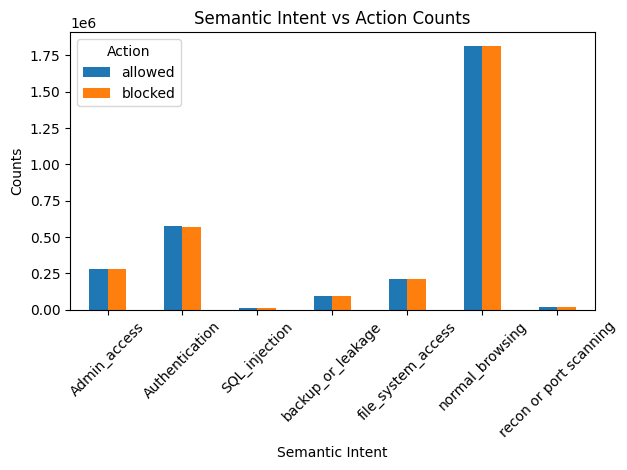

In [33]:
# threat label semantic analysis 
# semantic intents as Authentication , Admin_access , file_system_access , SQL_injection , recon or port scanning , normal_browsing , backup_or_leakage

# Add this cell after the existing code for request_path analysis

import re

# Function to classify semantic intent based on request_path
def classify_semantic_intent(path):
    if pd.isna(path):
        return 'unknown'
    path_lower = path.lower()
    
    # Authentication: login-related paths
    if any(keyword in path_lower for keyword in ['login', 'auth', 'api/login']):
        return 'Authentication'
    
    # Admin_access: admin-related paths
    elif 'admin' in path_lower:
        return 'Admin_access'
    
    # file_system_access: paths accessing files or directories like /etc/passwd, /files, etc.
    elif any(keyword in path_lower for keyword in ['passwd', 'files', 'home', 'root', 'bash']):
        return 'file_system_access'
    
    # SQL_injection: paths with SQL keywords in query
    elif any(keyword in path_lower for keyword in ['drop table', 'union select']):
        return 'SQL_injection'
    
    # recon or port scanning: paths with tools like nmap, hydra, sqlmap
    elif any(keyword in path_lower for keyword in ['nmap', 'hydra', 'sqlmap']):
        return 'recon or port scanning'
    
    # backup_or_leakage: backup or download related
    elif any(keyword in path_lower for keyword in ['backup', 'download']):
        return 'backup_or_leakage'
    
    # normal_browsing: basic paths like /, /index.php, /dashboard
    elif any(keyword in path_lower for keyword in ['/', 'index.php', 'dashboard']) and '?' not in path:
        return 'normal_browsing'
    
    # Default to normal_browsing if no specific match
    else:
        return 'normal_browsing'

# Apply the classification to the dataframe
Data_source_pl = Data_source_pl.with_columns([
    pl.col('request_path').map_elements(classify_semantic_intent, return_dtype=pl.Utf8).alias('semantic_intent')
])

# Now, group by semantic_intent, threat_label, action and count
semantic_analysis = Data_source_pl.group_by(['semantic_intent', 'threat_label', 'action']).agg([
    pl.len().alias('count')
]).sort(['semantic_intent', 'threat_label', 'action'])

print("Semantic Intent x Threat Label x Action Analysis:")
print(semantic_analysis)


#create bar chart for semantic intent vs allowed and blocked counts
import matplotlib.pyplot as plt

semantic_summary = Data_source_pl.group_by(['semantic_intent', 'action']).agg([
    pl.len().alias('count')
]).sort(['semantic_intent', 'action'])

semantic_df = semantic_summary.to_pandas()     
pivot_df = semantic_df.pivot(index='semantic_intent', columns='action', values='count').fillna(0)
pivot_df.plot(kind='bar', stacked=False)
plt.title('Semantic Intent vs Action Counts')
plt.xlabel('Semantic Intent')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.legend(title='Action')
plt.tight_layout()
plt.show()




Most probably action taken column is derived from the dataset

/tmp/ipykernel_5433/4167968609.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intent_data['percentage'] = (intent_data['count'] / total_count) * 100
/tmp/ipykernel_5433/4167968609.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intent_data['percentage'] = (intent_data['count'] / total_count) * 100
/tmp/ipykernel_5433/4167968609.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

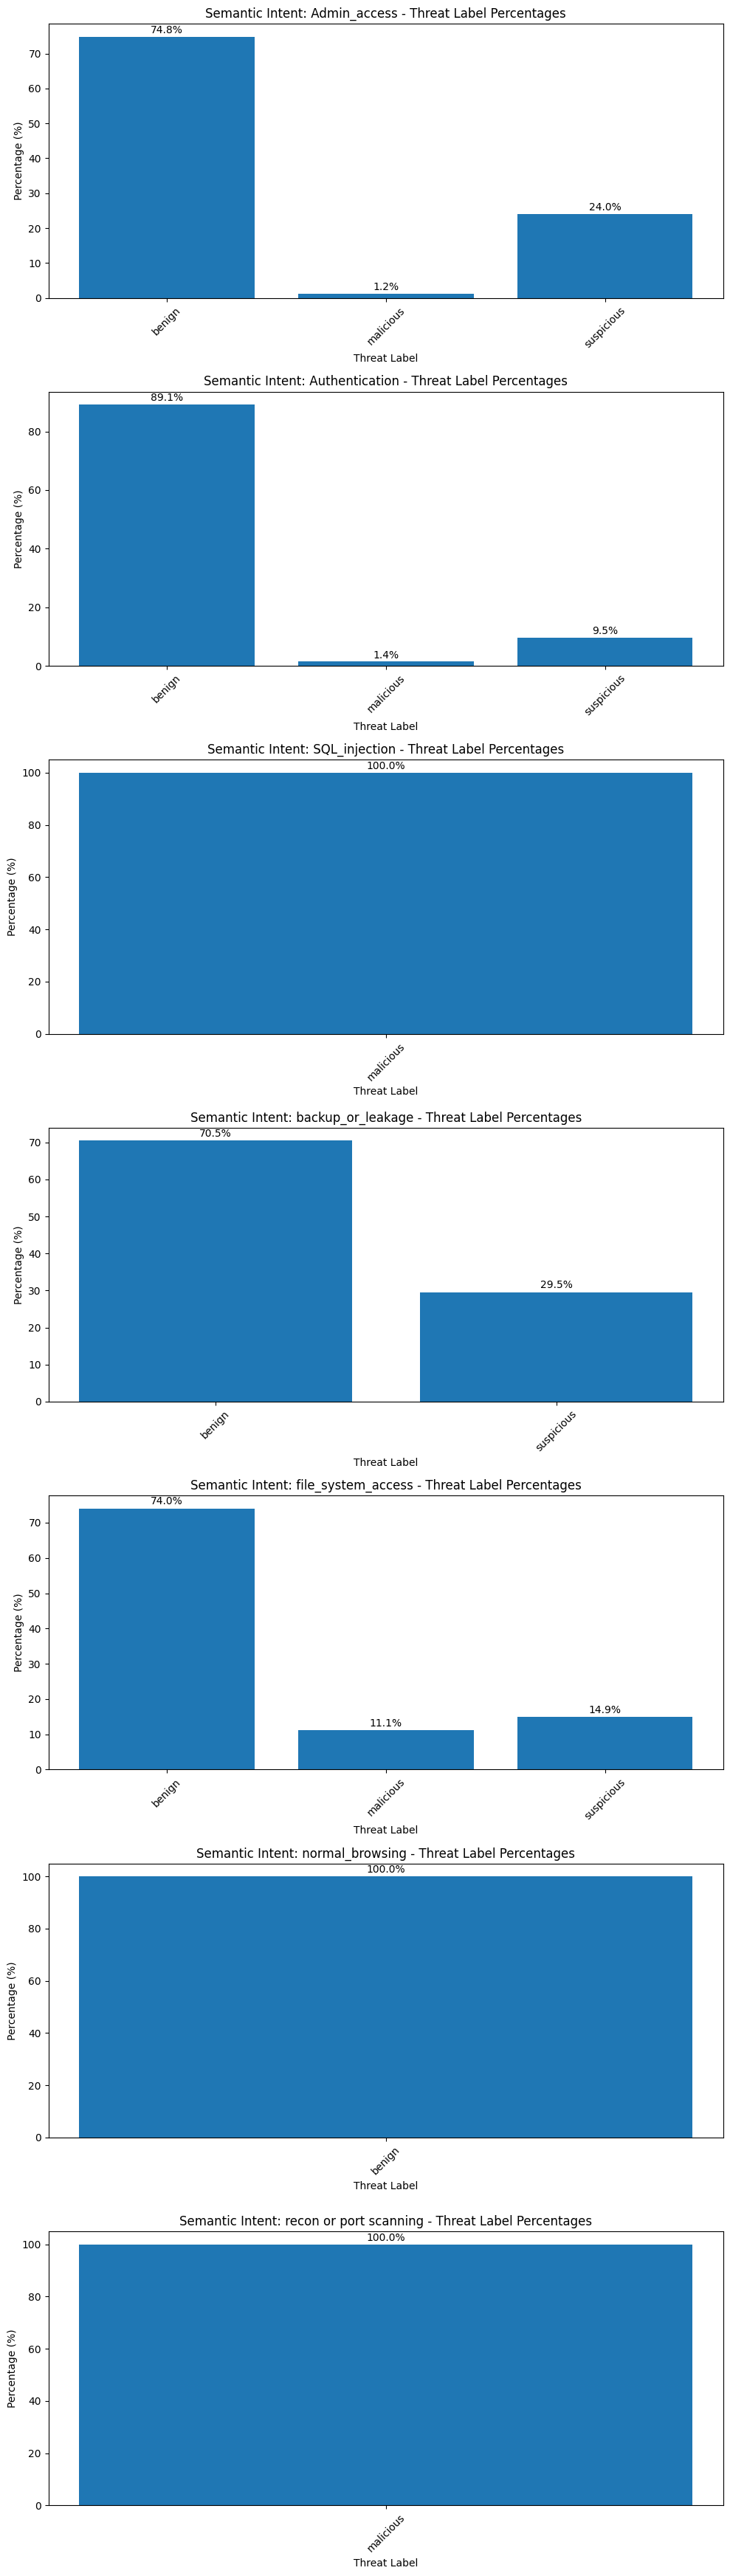

In [36]:
# Add this as a new cell or replace the existing plotting code

import matplotlib.pyplot as plt

# Assuming semantic_threat_summary is already computed as in your code
semantic_threat_df = semantic_threat_summary.to_pandas()

# Get unique semantic intents
unique_intents = semantic_threat_df['semantic_intent'].unique()

# Create a figure with subplots (7 charts in a grid, e.g., 4x2 or 7x1)
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 35))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten for easy indexing

for i, intent in enumerate(unique_intents):
    # Filter data for this intent
    intent_data = semantic_threat_df[semantic_threat_df['semantic_intent'] == intent]
    
    # Calculate percentages
    total_count = intent_data['count'].sum()
    intent_data['percentage'] = (intent_data['count'] / total_count) * 100
    
    # Plot bar chart
    axes[i].bar(intent_data['threat_label'], intent_data['percentage'])
    axes[i].set_title(f'Semantic Intent: {intent} - Threat Label Percentages')
    axes[i].set_xlabel('Threat Label')
    axes[i].set_ylabel('Percentage (%)')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add percentage labels on bars
    for j, v in enumerate(intent_data['percentage']):
        axes[i].text(j, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


/tmp/ipykernel_5433/491234630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intent_data['percentage'] = (intent_data['count'] / total_count) * 100
/tmp/ipykernel_5433/491234630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intent_data['percentage'] = (intent_data['count'] / total_count) * 100
/tmp/ipykernel_5433/491234630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

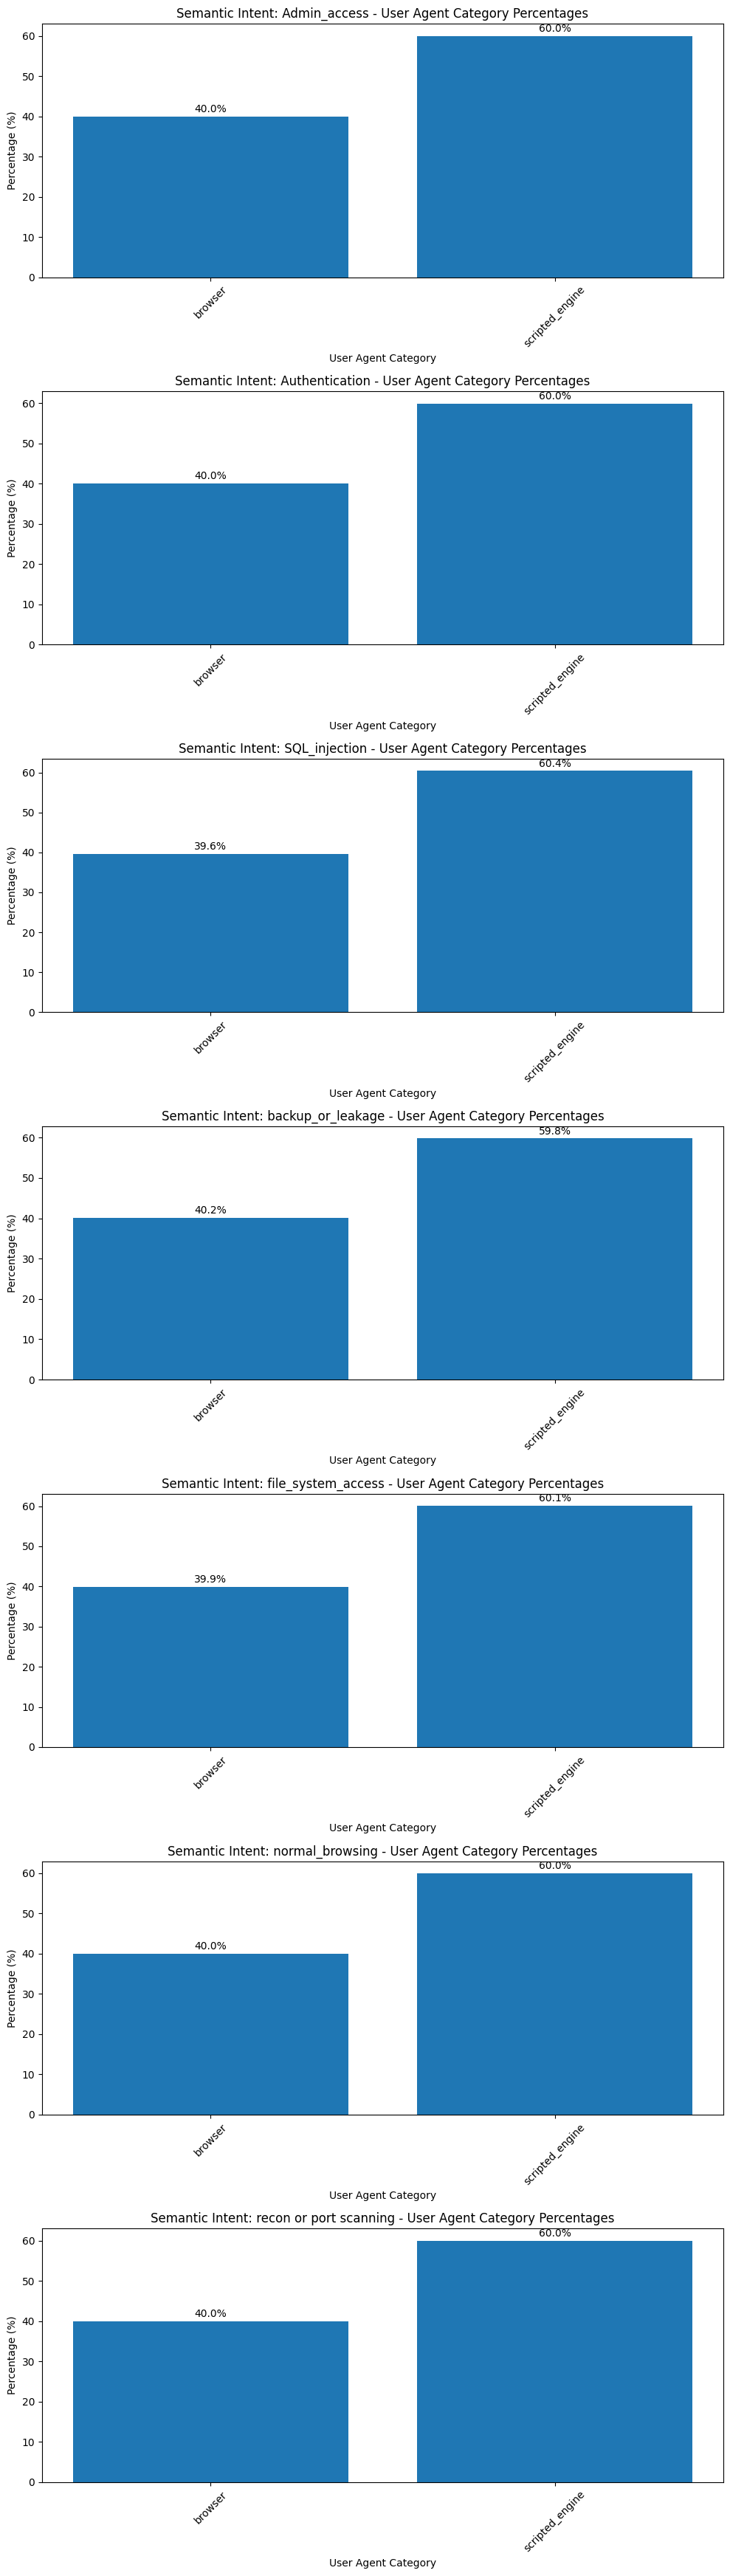

In [37]:
# Add this as a new cell after the existing plotting code

import matplotlib.pyplot as plt

# Group by semantic_intent and user_agent_category
semantic_user_agent_summary = Data_source_pl.group_by(['semantic_intent', 'user_agent_category']).agg([
    pl.len().alias('count')
]).sort(['semantic_intent', 'user_agent_category'])

semantic_user_agent_df = semantic_user_agent_summary.to_pandas()

# Get unique semantic intents
unique_intents = semantic_user_agent_df['semantic_intent'].unique()

# Create a figure with subplots (7 charts in a grid, e.g., 4x2 or 7x1)
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 35))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten for easy indexing

for i, intent in enumerate(unique_intents):
    # Filter data for this intent
    intent_data = semantic_user_agent_df[semantic_user_agent_df['semantic_intent'] == intent]
    
    # Calculate percentages
    total_count = intent_data['count'].sum()
    intent_data['percentage'] = (intent_data['count'] / total_count) * 100
    
    # Plot bar chart
    axes[i].bar(intent_data['user_agent_category'], intent_data['percentage'])
    axes[i].set_title(f'Semantic Intent: {intent} - User Agent Category Percentages')
    axes[i].set_xlabel('User Agent Category')
    axes[i].set_ylabel('Percentage (%)')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Add percentage labels on bars
    for j, v in enumerate(intent_data['percentage']):
        axes[i].text(j, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

/tmp/ipykernel_5433/3477058995.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_data['percentage'] = (pair_data['count'] / total_count) * 100
/tmp/ipykernel_5433/3477058995.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_data['percentage'] = (pair_data['count'] / total_count) * 100
/tmp/ipykernel_5433/3477058995.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

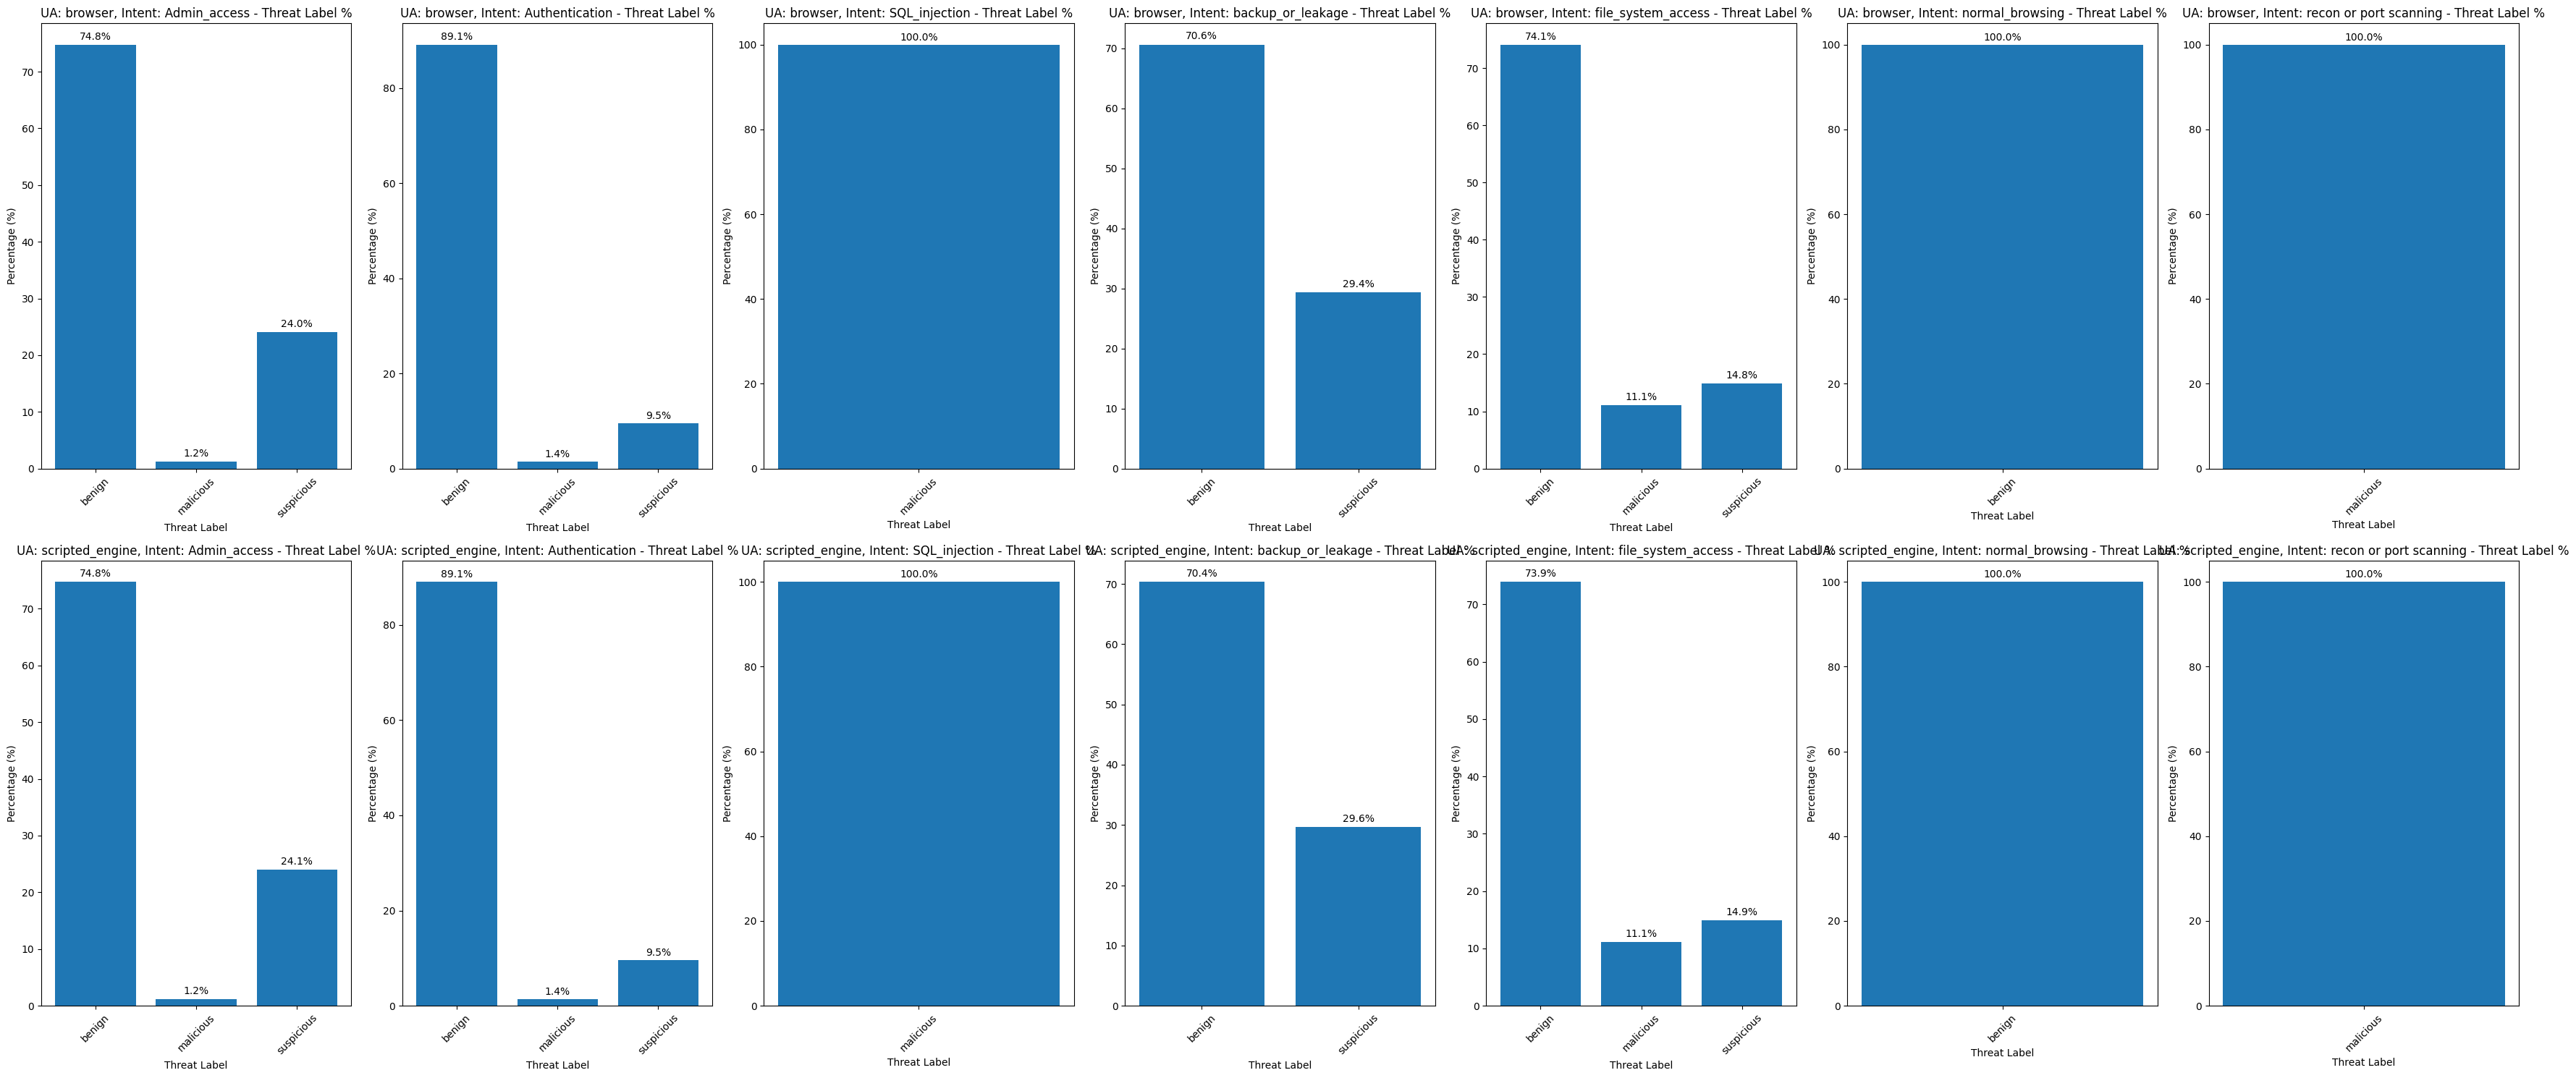

In [38]:
# Add this as a new cell after the existing plotting code

import matplotlib.pyplot as plt

# Group by user_agent_category, semantic_intent, and threat_label
ua_intent_threat_summary = Data_source_pl.group_by(['user_agent_category', 'semantic_intent', 'threat_label']).agg([
    pl.len().alias('count')
]).sort(['user_agent_category', 'semantic_intent', 'threat_label'])

ua_intent_threat_df = ua_intent_threat_summary.to_pandas()

# Get unique user_agent_categories and semantic_intents
unique_ua_categories = ua_intent_threat_df['user_agent_category'].unique()
unique_intents = ua_intent_threat_df['semantic_intent'].unique()

# Create a figure with subplots (3 rows for ua categories, 7 columns for intents)
fig, axes = plt.subplots(nrows=len(unique_ua_categories), ncols=len(unique_intents), figsize=(35, 15))  # Adjust figsize as needed

for i, ua_cat in enumerate(unique_ua_categories):
    for j, intent in enumerate(unique_intents):
        # Filter data for this ua_cat and intent
        pair_data = ua_intent_threat_df[(ua_intent_threat_df['user_agent_category'] == ua_cat) & (ua_intent_threat_df['semantic_intent'] == intent)]
        
        if not pair_data.empty:
            # Calculate percentages
            total_count = pair_data['count'].sum()
            pair_data['percentage'] = (pair_data['count'] / total_count) * 100
            
            # Plot bar chart
            axes[i, j].bar(pair_data['threat_label'], pair_data['percentage'])
            axes[i, j].set_title(f'UA: {ua_cat}, Intent: {intent} - Threat Label %')
            axes[i, j].set_xlabel('Threat Label')
            axes[i, j].set_ylabel('Percentage (%)')
            axes[i, j].tick_params(axis='x', rotation=45)
            
            # Add percentage labels on bars
            for k, v in enumerate(pair_data['percentage']):
                axes[i, j].text(k, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')
        else:
            axes[i, j].set_title(f'UA: {ua_cat}, Intent: {intent} - No Data')
            axes[i, j].set_xlabel('Threat Label')
            axes[i, j].set_ylabel('Percentage (%)')

plt.tight_layout()
plt.show()

In [54]:
# average bytes transferred x intent x threat level analysis for check Bytes are nearly identical identical → synthetic weakness

bytes_intent_threat_summary = Data_source_pl.group_by(['semantic_intent', 'threat_label']).agg([
    pl.col('bytes_transferred').mean().alias('average_bytes_transferred')
]).sort(['semantic_intent', 'threat_label'])

# print as a list 

print("Average Bytes Transferred x Semantic Intent x Threat Level:")
for row in bytes_intent_threat_summary.iter_rows():
    print(f"Semantic Intent: {row[0]}, Threat Level: {row[1]}, Average Bytes Transferred: {row[2]}")    






Average Bytes Transferred x Semantic Intent x Threat Level:
Semantic Intent: Admin_access, Threat Level: benign, Average Bytes Transferred: 25023.964379864574
Semantic Intent: Admin_access, Threat Level: malicious, Average Bytes Transferred: 25280.403796507213
Semantic Intent: Admin_access, Threat Level: suspicious, Average Bytes Transferred: 25050.10289776899
Semantic Intent: Authentication, Threat Level: benign, Average Bytes Transferred: 25061.53338064696
Semantic Intent: Authentication, Threat Level: malicious, Average Bytes Transferred: 25026.046044864226
Semantic Intent: Authentication, Threat Level: suspicious, Average Bytes Transferred: 25078.648874261075
Semantic Intent: SQL_injection, Threat Level: malicious, Average Bytes Transferred: 24999.72925764192
Semantic Intent: backup_or_leakage, Threat Level: benign, Average Bytes Transferred: 25042.918882369122
Semantic Intent: backup_or_leakage, Threat Level: suspicious, Average Bytes Transferred: 24927.464108730506
Semantic Inten

In [56]:
#rare request paths analysis by getting inverse frequency

total_requests = Data_source_pl.height
request_path_freq = Data_source_pl.group_by('request_path').agg([
    pl.len().alias('frequency')
])

request_path_freq = request_path_freq.with_columns([
    (pl.lit(total_requests) / pl.col('frequency')).alias('inverse_frequency')
])

# Sort by inverse frequency to get rare request paths
rare_request_paths = request_path_freq.sort('inverse_frequency', descending=True)
print("Rare Request Paths by Inverse Frequency:")
for row in rare_request_paths.iter_rows():
    print(f"Request Path: {row[0]}, Inverse Frequency: {row[2]}")

Rare Request Paths by Inverse Frequency:
Request Path: /download?hydra, Inverse Frequency: 37974.6835443038
Request Path: /files?sqlmap, Inverse Frequency: 35928.14371257485
Request Path: /files?UNION SELECT, Inverse Frequency: 34883.72093023256
Request Path: /download?UNION SELECT, Inverse Frequency: 34482.75862068965
Request Path: /upload?/etc/passwd, Inverse Frequency: 34285.71428571428
Request Path: /backup?DROP TABLE, Inverse Frequency: 34090.90909090909
Request Path: /files?nmap, Inverse Frequency: 33707.86516853933
Request Path: /backup?/etc/passwd, Inverse Frequency: 32258.064516129034
Request Path: /files?hydra, Inverse Frequency: 31914.893617021276
Request Path: /backup?sqlmap, Inverse Frequency: 31413.612565445026
Request Path: /files?DROP TABLE, Inverse Frequency: 31413.612565445026
Request Path: /backup?UNION SELECT, Inverse Frequency: 31250.0
Request Path: /backup?hydra, Inverse Frequency: 31088.082901554404
Request Path: /download?DROP TABLE, Inverse Frequency: 31088.082

In [57]:
mismatch_score = (
    Data_source_pl
    .with_columns(
        ((pl.col("semantic_intent").is_in(
            ["SQL_injection", "file_system_access", "recon or port scanning"]
        )) &
        (pl.col("threat_label") == "benign"))
        .cast(pl.Int8)
        .alias("mismatch")
    )
    .select(pl.mean("mismatch").alias("mismatch_rate"))
)

print(mismatch_score)


shape: (1, 1)
┌───────────────┐
│ mismatch_rate │
│ ---           │
│ f64           │
╞═══════════════╡
│ 0.052838      │
└───────────────┘


6,000,000 × 0.0528 ≈ 316,800 events , That’s ~317,000 benign-labeled attacks